In [69]:
#This code is written by : Nassereddine BELGHITH, data Scientist at LANSROD Tech
#Per Mail : nasreedien.belguith@gmail.com

# Disable warnings 
import warnings
warnings.filterwarnings('ignore')
#set Matplotlib inline plotting
%matplotlib inline
#load packages
from pyspark.sql import SparkSession
from pyspark_dist_explore import hist,distplot
import matplotlib.pyplot as plt
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas as pd
from spark_stratifier import StratifiedCrossValidator
from pyspark.ml.feature import Imputer
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from IPython.display import display
from pyspark.mllib.evaluation import BinaryClassificationMetrics


In [70]:
# Starting the spark session and reading data
#Data is stored in a local machine 

spark = SparkSession \
    .builder \
    .getOrCreate()

train = spark.read.csv("/home/zied/Desktop/WA_Fn-UseC_-Telco-Customer-Churn.csv",header=True, inferSchema=True)

In [71]:
#Print the schema of the spark dataframe 
train.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



In [72]:
#convert Dataframe to binary 
#Object : one-hot encoding 

from pyspark.sql.functions import when   
train_new = train.withColumn('gender', when(train.gender == 'Male',1).otherwise(0))\
                 .withColumn('Partner', when(train.Partner == 'Yes', 1).otherwise(0))\
                 .withColumn('Dependents', when(train.Dependents == 'Yes', 1).otherwise(0))\
                 .withColumn('PhoneService', when(train.PhoneService == 'Yes',1).otherwise(0))\
                 .withColumn('PaperlessBilling',when(train.PaperlessBilling == 'Yes',1).otherwise(0))\
                 .withColumn('TechSupport',when(train.TechSupport == 'Yes',1).otherwise(0))\
                 .withColumn('MultipleLines',when(train.MultipleLines == 'Yes',1).otherwise(0))\
                 .withColumn('InternetService_DSL',when(train.InternetService == 'DSL',1).otherwise(0))\
                 .withColumn('InternetService_Optic_Fiber',when(train.InternetService == 'Fiber optic' ,1).otherwise(0))\
                 .withColumn('No_InternetService',when(train.InternetService == 'No',1).otherwise(0))\
                 .withColumn('OnlineSecurity',when(train.OnlineSecurity =='Yes',1).otherwise(0))\
                 .withColumn('OnlineBackup',when(train.OnlineBackup == 'Yes',1).otherwise(0))\
                 .withColumn('DeviceProtection',when(train.DeviceProtection == 'Yes',1).otherwise(0))\
                 .withColumn('StreamingMovies',when(train.StreamingMovies == 'Yes',1).otherwise(0))\
                 .withColumn('StreamingTV',when(train.StreamingTV == 'Yes',1).otherwise(0))\
                 .withColumn('Churn', when(train.Churn == 'Yes', 1).otherwise(0))\
                 .withColumn('month_to_month_contract',when(train.Contract=='Month-to-month',1).otherwise(0))\
                 .withColumn('year_to_year_contract',when(train.Contract == 'One year',1).otherwise(0))\
                 .withColumn('two_year_contact',when(train.Contract == 'Two year',1).otherwise(0))\
                 .withColumn('Electronic_check_PaymentMethod',when(train.PaymentMethod == 'Electronic check',1).otherwise(0))\
                 .withColumn('Mailed_check_PaymentMethod',when(train.PaymentMethod == 'Mailed check',1).otherwise(0))\
                 .withColumn('Credit_card_PaymentMethod',when(train.PaymentMethod == 'Credit card (automatic)',1 ).otherwise(0))


In [73]:
#Test the encoding of the feature two_year_contact 
train_new.select('two_year_contact').show()

+----------------+
|two_year_contact|
+----------------+
|               0|
|               0|
|               0|
|               0|
|               0|
|               0|
|               0|
|               0|
|               0|
|               0|
|               0|
|               1|
|               0|
|               0|
|               0|
|               1|
|               0|
|               1|
|               0|
|               0|
+----------------+
only showing top 20 rows



In [74]:
#Test the encoding of the feature month_to_month_contract
train_new.select('month_to_month_contract').show()

+-----------------------+
|month_to_month_contract|
+-----------------------+
|                      1|
|                      0|
|                      1|
|                      0|
|                      1|
|                      1|
|                      1|
|                      1|
|                      1|
|                      0|
|                      1|
|                      0|
|                      0|
|                      1|
|                      1|
|                      0|
|                      0|
|                      0|
|                      1|
|                      1|
+-----------------------+
only showing top 20 rows



In [75]:
#display the values of the feature Contract from where I extracted some other features
train.select('Contract').show()
##Test the encoding of the feature year_to_year_contract
train_new.select('year_to_year_contract').show()

+--------------+
|      Contract|
+--------------+
|Month-to-month|
|      One year|
|Month-to-month|
|      One year|
|Month-to-month|
|Month-to-month|
|Month-to-month|
|Month-to-month|
|Month-to-month|
|      One year|
|Month-to-month|
|      Two year|
|      One year|
|Month-to-month|
|Month-to-month|
|      Two year|
|      One year|
|      Two year|
|Month-to-month|
|Month-to-month|
+--------------+
only showing top 20 rows

+---------------------+
|year_to_year_contract|
+---------------------+
|                    0|
|                    1|
|                    0|
|                    1|
|                    0|
|                    0|
|                    0|
|                    0|
|                    0|
|                    1|
|                    0|
|                    0|
|                    1|
|                    0|
|                    0|
|                    0|
|                    1|
|                    0|
|                    0|
|                    0|
+-------------

In [77]:
#display the values of the feature PaymentMethod from where I extracted some other features
train.select('PaymentMethod').show()

+--------------------+
|       PaymentMethod|
+--------------------+
|    Electronic check|
|        Mailed check|
|        Mailed check|
|Bank transfer (au...|
|    Electronic check|
|    Electronic check|
|Credit card (auto...|
|        Mailed check|
|    Electronic check|
|Bank transfer (au...|
|        Mailed check|
|Credit card (auto...|
|Credit card (auto...|
|Bank transfer (au...|
|    Electronic check|
|Credit card (auto...|
|        Mailed check|
|Bank transfer (au...|
|Credit card (auto...|
|    Electronic check|
+--------------------+
only showing top 20 rows



In [78]:
##Test the encoding of the feature Credit_card_PaymentMethod
train_new.select('Credit_card_PaymentMethod').show()

+-------------------------+
|Credit_card_PaymentMethod|
+-------------------------+
|                        0|
|                        0|
|                        0|
|                        0|
|                        0|
|                        0|
|                        1|
|                        0|
|                        0|
|                        0|
|                        0|
|                        1|
|                        1|
|                        0|
|                        0|
|                        1|
|                        0|
|                        0|
|                        1|
|                        0|
+-------------------------+
only showing top 20 rows



In [79]:
##Test the encoding of the feature InternetService_Optic_Fiber
train_new.select('InternetService_Optic_Fiber').show()

+---------------------------+
|InternetService_Optic_Fiber|
+---------------------------+
|                          0|
|                          0|
|                          0|
|                          0|
|                          1|
|                          1|
|                          1|
|                          0|
|                          1|
|                          0|
|                          0|
|                          0|
|                          1|
|                          1|
|                          1|
|                          1|
|                          0|
|                          1|
|                          0|
|                          1|
+---------------------------+
only showing top 20 rows



In [80]:
##print the values of the feature MonthlyCharges
train_new.select('MonthlyCharges').show()

+--------------+
|MonthlyCharges|
+--------------+
|         29.85|
|         56.95|
|         53.85|
|          42.3|
|          70.7|
|         99.65|
|          89.1|
|         29.75|
|         104.8|
|         56.15|
|         49.95|
|         18.95|
|        100.35|
|         103.7|
|         105.5|
|        113.25|
|         20.65|
|         106.7|
|          55.2|
|         90.05|
+--------------+
only showing top 20 rows



In [81]:
#print the schema of the spark dataframe 
#As the type of some columns is string I have changed thier types to double 
train_new.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: integer (nullable = false)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: integer (nullable = false)
 |-- Dependents: integer (nullable = false)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: integer (nullable = false)
 |-- MultipleLines: integer (nullable = false)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: integer (nullable = false)
 |-- OnlineBackup: integer (nullable = false)
 |-- DeviceProtection: integer (nullable = false)
 |-- TechSupport: integer (nullable = false)
 |-- StreamingTV: integer (nullable = false)
 |-- StreamingMovies: integer (nullable = false)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: integer (nullable = false)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: integer (nullable = false)
 |-- InternetService_DSL: integer (nullable = false)
 |-

In [82]:
#Convert MonthlyCharges and TotalCharges from string to double

train_new = train_new.withColumn("TotalCharges",train_new["TotalCharges"].cast(DoubleType()).alias("TotalCharges"))

In [83]:
train_new.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: integer (nullable = false)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: integer (nullable = false)
 |-- Dependents: integer (nullable = false)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: integer (nullable = false)
 |-- MultipleLines: integer (nullable = false)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: integer (nullable = false)
 |-- OnlineBackup: integer (nullable = false)
 |-- DeviceProtection: integer (nullable = false)
 |-- TechSupport: integer (nullable = false)
 |-- StreamingTV: integer (nullable = false)
 |-- StreamingMovies: integer (nullable = false)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: integer (nullable = false)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: integer (nullable = false)
 |-- InternetService_DSL: integer (nullable = false)
 |-

In [85]:
#display a summary of some column of our dataframe
display(train_new.select("Churn","MonthlyCharges","TotalCharges").describe().toPandas())
#Subscribers pay a lot ( 18 to 119 $ per month)

,summary,Churn,MonthlyCharges,TotalCharges
0,count,7043,7043,7032
1,mean,0.2653698707936959,64.76169246059922,2283.3004408418697
2,stddev,0.44156130512194697,30.090047097678482,2266.771361883145
3,min,0,18.25,18.8
4,max,1,118.75,8684.8


In [86]:
# display missing values
display(train_new.select([count(when(isnan(c), c)).alias(c) for c in train_new.columns]).toPandas())
display(train_new.select([count(when(col(c).isNull(), c)).alias(c) for c in train_new.columns]).toPandas())

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,Churn,InternetService_DSL,InternetService_Optic_Fiber,No_InternetService,month_to_month_contract,year_to_year_contract,two_year_contact,Electronic_check_PaymentMethod,Mailed_check_PaymentMethod,Credit_card_PaymentMethod
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,Churn,InternetService_DSL,InternetService_Optic_Fiber,No_InternetService,month_to_month_contract,year_to_year_contract,two_year_contact,Electronic_check_PaymentMethod,Mailed_check_PaymentMethod,Credit_card_PaymentMethod
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
#display a summary of some column of our dataframe
display(train_new.describe().toPandas())

,summary,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,Churn,InternetService_DSL,InternetService_Optic_Fiber,No_InternetService,month_to_month_contract,year_to_year_contract,two_year_contact,Electronic_check_PaymentMethod,Mailed_check_PaymentMethod,Credit_card_PaymentMethod
0,count,7043,7043,7043,7043,7043,7043,7043,7043,7043,...,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
1,mean,None,0.504756495811444,0.1621468124378816,0.4830327985233565,0.2995882436461735,32.37114865824223,0.9031662643759761,0.42183728524776376,None,...,0.2653698707936959,0.34374556297032516,0.4395854039471816,0.21666903308249325,0.5501916796819537,0.20914383075394008,0.24066448956410622,0.3357944057929859,0.22887973874769274,0.2161010932841119
2,stddev,None,0.5000128736471523,0.3686116056100135,0.49974751071998735,0.4581101675100144,24.559481023094442,0.29575223178363513,0.49388786554556857,None,...,0.44156130512194697,0.47499114209424825,0.49637189641843843,0.41200444754786414,0.49750973742108945,0.4067261693558548,0.4275173022982706,0.47230095824332957,0.42014148445602056,0.4116132488536575
3,min,0002-ORFBO,0,0,0,0,0,0,0,DSL,...,0,0,0,0,0,0,0,0,0,0
4,max,9995-HOTOH,1,1,1,1,72,1,1,No,...,1,1,1,1,1,1,1,1,1,1


(array([5174.,    0., 1869.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <a list of 3 Patch objects>)

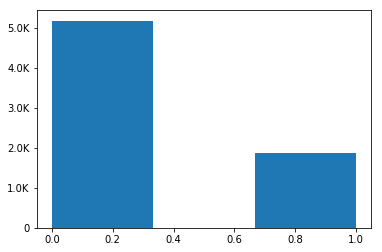

In [18]:
# PLoting the distribution of the labels
fig, ax = plt.subplots()
hist(ax, train_new.select("Churn"), bins = 3)

(array([1300.,  581.,  442.,  386.,  350.,  337.,  310.,  231.,  216.,
         152.,  155.,  148.,  124.,  139.,  130.,  115.,  112.,  111.,
         123.,  108.,  109.,   96.,  124.,   83.,   87.,  107.,   99.,
         102.,   77.,   86.,   77.,   70.,   67.,   60.,   51.,   45.,
          50.,   33.,   26.,   13.]),
 array([  18.8 ,  235.45,  452.1 ,  668.75,  885.4 , 1102.05, 1318.7 ,
        1535.35, 1752.  , 1968.65, 2185.3 , 2401.95, 2618.6 , 2835.25,
        3051.9 , 3268.55, 3485.2 , 3701.85, 3918.5 , 4135.15, 4351.8 ,
        4568.45, 4785.1 , 5001.75, 5218.4 , 5435.05, 5651.7 , 5868.35,
        6085.  , 6301.65, 6518.3 , 6734.95, 6951.6 , 7168.25, 7384.9 ,
        7601.55, 7818.2 , 8034.85, 8251.5 , 8468.15, 8684.8 ]),
 <a list of 40 Patch objects>)

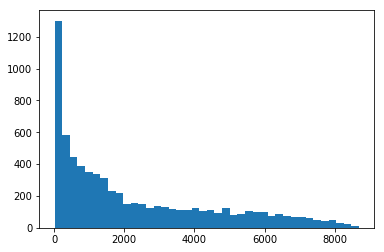

In [19]:
import matplotlib.pyplot as plt
# Show histogram of the 'TotalCharges' column
bins, counts = train_new.select('TotalCharges').rdd.flatMap(lambda x: x).histogram(40)

# This is a bit awkward but I believe this is the correct way to do it 
plt.hist(bins[:-1], bins=bins, weights=counts)

In [20]:
train_new.describe().toPandas().transpose()


,0,1,2,3,4
summary,count,mean,stddev,min,max
customerID,7043,None,None,0002-ORFBO,9995-HOTOH
gender,7043,0.504756495811444,0.5000128736471523,0,1
SeniorCitizen,7043,0.1621468124378816,0.3686116056100135,0,1
Partner,7043,0.4830327985233565,0.49974751071998735,0,1
Dependents,7043,0.2995882436461735,0.4581101675100144,0,1
tenure,7043,32.37114865824223,24.559481023094442,0,72
PhoneService,7043,0.9031662643759761,0.29575223178363513,0,1
MultipleLines,7043,0.42183728524776376,0.49388786554556857,0,1
InternetService,7043,None,None,DSL,No


In [21]:
train_new.select('InternetService_DSL').count()

7043

In [22]:
train_new.select('Churn').count()

7043

In [23]:
train_bd = train_new.groupBy("InternetService_DSL").agg(count(when((col("Churn")==1),True)),count(when(col("InternetService_DSL")==1,True)))
train_bd.describe().toPandas().transpose()


,0,1,2,3,4
summary,count,mean,stddev,min,max
InternetService_DSL,2,0.5,0.7071067811865476,0,1
count(CASE WHEN (Churn = 1) THEN true END),2,934.5,672.4585489084067,459,1410
count(CASE WHEN (InternetService_DSL = 1) THEN true END),2,1210.5,1711.9055172526316,0,2421


In [24]:
print('Percentage of Unsubscribed clients who have DSL internet service =',(2421/7043*100),'%')
#34 % of unscubscribers have DSL internet service 

Percentage of Unsubscribed clients who have DSL internet service = 34.37455629703251 %


In [25]:
train_bd1 = train_new.groupBy("Churn").agg(count(when((col("Churn")==1),True)))

In [26]:
train_bd1.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Churn,2,0.5,0.7071067811865476,0,1
count(CASE WHEN (Churn = 1) THEN true END),2,934.5,1321.5825740376574,0,1869


In [27]:
print('Percentage of Unsubscribed clients =',(1869/7043*100),'%')
#26.5 % of clients have unscubscribed 

Percentage of Unsubscribed clients = 26.536987079369588 %


In [28]:
# compute the percentage of unsubscribers 
train_bd2 = train_new.groupBy("InternetService_Optic_Fiber").agg(count(when((col("InternetService_Optic_Fiber")==1),True)))
train_bd2.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
InternetService_Optic_Fiber,2,0.5,0.7071067811865476,0,1
count(CASE WHEN (InternetService_Optic_Fiber = 1) THEN true END),2,1548.0,2189.202594553551,0,3096


In [29]:
print('Percentage of Unsubscribed clients who have optic fiber internet service',(3096/7043*100),'%')
#43.95 % of clients have optic fiber internet service 

Percentage of Unsubscribed clients who have optic fiber internet service 43.958540394718156 %


In [30]:
# compute the percentage of unsubscribers using PaperlessBilling method

train_bd3 = train_new.groupBy("PaperlessBilling").agg(count(when((col("PaperlessBilling")==1),True)))
train_bd3.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
PaperlessBilling,2,0.5,0.7071067811865476,0,1
count(CASE WHEN (PaperlessBilling = 1) THEN true END),2,2085.5,2949.34238432909,0,4171


In [31]:
print('Percentage of Unsubscribed clients who use PaperlessBilling service',(4171/7043*100),'%')
#59.22 % of clients have optic fiber internet service 

Percentage of Unsubscribed clients who use PaperlessBilling service 59.22192247621753 %


In [32]:
# compute the percentage of male clients & female clients
train_bd4 = train_new.groupBy("gender").agg(count(when((col("gender")==1),True)))
train_bd4.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
gender,2,0.5,0.7071067811865476,0,1
count(CASE WHEN (gender = 1) THEN true END),2,1777.5,2513.7646071181766,0,3555


In [33]:
#Display the percentage of male clients
print('Percentage of male clients',(3555/7043*100),'%')
# 50.47% of male clients 

Percentage of male clients 50.4756495811444 %


In [34]:
# compute the percentage of clients who have phone service
train_bd5 = train_new.groupBy("PhoneService").agg(count(when((col("PhoneService")==1),True)))
train_bd5.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
PhoneService,2,0.5,0.7071067811865476,0,1
count(CASE WHEN (PhoneService = 1) THEN true END),2,3180.5,4497.906235127629,0,6361


In [35]:
print('Percentage of clients who have phone service ',(6361/7043*100),'%')
# 50.47% of male clients 

Percentage of clients who have phone service  90.31662643759762 %


In [36]:
#Cleaning the dataset then caching it 
final_test_data = train_new.drop('State').drop('PaymentMethod') \
    .drop('Contract').drop('InternetService') \
    .drop('customerID').cache()

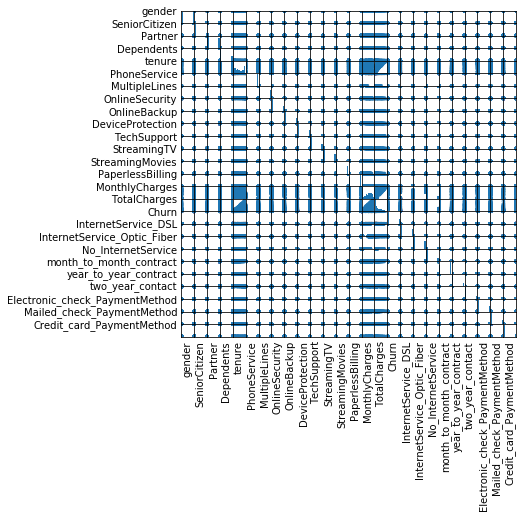

In [37]:
#Correlation matrix (most correlated features to the churn)
numeric_features = [t[0] for t in final_test_data.dtypes if t[1] == 'int' or t[1] == 'double']

sampled_data = final_test_data.select(numeric_features).sample(False, 0.10).toPandas()

axs = pd.plotting.scatter_matrix(sampled_data, figsize=(6, 6));

# Rotate axis labels and remove axis ticks
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [38]:
#Correlation to the churn 
sampled_data.corr()['Churn'].sort_values()

tenure                           -0.383915
two_year_contact                 -0.300438
TotalCharges                     -0.230693
year_to_year_contract            -0.224916
No_InternetService               -0.205030
OnlineSecurity                   -0.161928
TechSupport                      -0.158350
Dependents                       -0.137736
Credit_card_PaymentMethod        -0.135902
Partner                          -0.129965
PhoneService                     -0.098205
InternetService_DSL              -0.090207
DeviceProtection                 -0.086858
OnlineBackup                     -0.079051
Mailed_check_PaymentMethod       -0.067503
MultipleLines                    -0.042646
gender                            0.020819
StreamingMovies                   0.048980
StreamingTV                       0.060902
MonthlyCharges                    0.137636
SeniorCitizen                     0.180702
PaperlessBilling                  0.200041
Electronic_check_PaymentMethod    0.249778
InternetSer

In [39]:
x = sampled_data.Churn
y = sampled_data.month_to_month_contract
import plotly.plotly as py
import plotly.tools as tls
import pylab as plt
import plotly 
import plotly.graph_objs as go
Churn = go.Histogram(
    x=x,
    name='Churn',
    opacity=0.75
)
month_to_month_contract = go.Histogram(
    x=y,
    name ='month_to_month_contract',
    opacity=0.75
)

data = [Churn, month_to_month_contract]
layout = go.Layout(barmode='group')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Distribution of churn by month_to_month_contract')


In [40]:
import numpy as np 
z = final_test_data.select('tenure').collect()
x= final_test_data.select('Churn').collect()
z=z/np.max(z)
#print(z.count())
Churn = go.Histogram(
    x=x,
    name='Churn',
    opacity=1
)
tenure = go.Histogram(
    x=z,
    name ='tenure',
    opacity=1
)

data = [Churn,tenure]
layout = go.Layout(barmode='group')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Distribution of churn by tenure')

In [41]:
w = final_test_data.select('InternetService_Optic_Fiber').collect()
x= final_test_data.select('Churn').collect()
#print(z.count())
Churn = go.Histogram(
    x=x,
    name='Churn',
    opacity=1
)
tenure = go.Histogram(
    x=w,
    name ='InternetService_Optic_Fiber',
    opacity=1
)

data = [Churn,tenure]
layout = go.Layout(barmode='group')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Distribution of churn by InternetService_Optic_Fiber')

In [42]:
#Cleaning the dataset and cachining it 
final_test_data = final_test_data.drop('PhoneService').drop('StreamingMovies').drop('gender')\
.drop('PaperlessBilling').drop('MonthlyCharges').drop('SeniorCitizen').drop('StreamingTV')\
.drop('TechSupport').drop('InternetService_DSL').drop('Credit_card_PaymentMethod')\
.drop('OnlineBackup').drop('Dependents').drop('year_to_year_contract').drop('Partner')\
.drop('OnlineSecurity').drop('TotalCharges').drop('MultipleLines').drop('StreamingTV')\
.drop('DeviceProtection').drop('Mailed_check_PaymentMethod').cache()

In [43]:
#display the final test  dataset 
pd.DataFrame(final_test_data.take(5), columns=final_test_data.columns).transpose()

,0,1,2,3,4
tenure,1,34,2,45,2
Churn,0,0,1,0,1
InternetService_Optic_Fiber,0,0,0,0,1
No_InternetService,0,0,0,0,0
month_to_month_contract,1,0,1,0,1
two_year_contact,0,0,0,0,0
Electronic_check_PaymentMethod,1,0,0,0,1


In [44]:
pd.DataFrame(final_test_data.take(5), columns=final_test_data.columns).transpose()

,0,1,2,3,4
tenure,1,34,2,45,2
Churn,0,0,1,0,1
InternetService_Optic_Fiber,0,0,0,0,1
No_InternetService,0,0,0,0,0
month_to_month_contract,1,0,1,0,1
two_year_contact,0,0,0,0,0
Electronic_check_PaymentMethod,1,0,0,0,1


In [45]:
#Applying the Decision Tree algorithm 
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import DecisionTree



def labelData(data):
    # label: row[end], features: row[0:end-1]
    data1 = data.map(lambda row: LabeledPoint(row[-1], row[:-1]))
    return data1

training_data, testing_data = labelData(final_test_data.rdd).randomSplit([0.8, 0.2])
model = DecisionTree.trainClassifier(training_data, numClasses=2, maxDepth=7,
                                     categoricalFeaturesInfo={2:2,3:2,4:2,5:2},
                                     impurity='gini', maxBins=32)
print(model.toDebugString())

DecisionTreeModel classifier of depth 7 with 215 nodes
  If (feature 2 in {0.0})
   If (feature 4 in {0.0})
    If (feature 5 in {1.0})
     If (feature 3 in {1.0})
      If (feature 0 <= 46.5)
       If (feature 0 <= 39.5)
        If (feature 0 <= 29.5)
         Predict: 0.0
        Else (feature 0 > 29.5)
         Predict: 0.0
       Else (feature 0 > 39.5)
        If (feature 0 <= 42.5)
         Predict: 0.0
        Else (feature 0 > 42.5)
         Predict: 0.0
      Else (feature 0 > 46.5)
       If (feature 0 <= 69.5)
        If (feature 0 <= 61.5)
         Predict: 0.0
        Else (feature 0 > 61.5)
         Predict: 0.0
       Else (feature 0 > 69.5)
        If (feature 0 <= 71.5)
         Predict: 0.0
        Else (feature 0 > 71.5)
         Predict: 0.0
     Else (feature 3 not in {1.0})
      If (feature 1 <= 0.5)
       If (feature 0 <= 23.5)
        Predict: 0.0
       Else (feature 0 > 23.5)
        If (feature 0 <= 71.5)
         Predict: 0.0
        Else (feature 0 > 71

In [46]:
#Model evaluation 
from pyspark.mllib.evaluation import MulticlassMetrics

def getPredictionsLabels(model, test_data):
    predictions = model.predict(test_data.map(lambda r: r.features))
    return predictions.zip(test_data.map(lambda r: r.label))

def printMetrics(predictions_and_labels):
    metrics = MulticlassMetrics(predictions_and_labels)
    print('Precision of True ', metrics.precision(1))
    print('Precision of False', metrics.precision(0))
    print('Recall of True    ', metrics.recall(1))
    print('Recall of False   ', metrics.recall(0))
    print('F-1 Score         ', metrics.fMeasure())
    print('Confusion Matrix\n', metrics.confusionMatrix().toArray())

predictions_and_labels = getPredictionsLabels(model, testing_data)

printMetrics(predictions_and_labels)

Precision of True  0.5840909090909091
Precision of False 0.7732379979570991
Recall of True     0.5365344467640919
Recall of False    0.8053191489361702
F-1 Score          0.7145877378435518
Confusion Matrix
 [[757. 183.]
 [222. 257.]]


In [47]:
#Now I have to equilibrate my learning dataset 
final_test_data.groupby('Churn').count().toPandas()

,Churn,count
0,1,1869
1,0,5174


In [49]:
#equilibrate the dataset
stratified_CV_data = final_test_data.sampleBy('Churn', fractions={0: 1869./5174, 1: 1.0}).cache()

stratified_CV_data.groupby('Churn').count().toPandas()

,Churn,count
0,1,1869
1,0,1841


In [50]:
training_data, testing_data = labelData(stratified_CV_data.rdd).randomSplit([0.8, 0.2])

model = DecisionTree.trainClassifier(training_data, numClasses=2, maxDepth=7,
                                     categoricalFeaturesInfo={2:2,3:2,4:2,5:2},
                                     impurity='gini', maxBins=32)

predictions_and_labels = getPredictionsLabels(model, testing_data)
printMetrics(predictions_and_labels)

Precision of True  0.6494845360824743
Precision of False 0.7130242825607064
Recall of True     0.5924764890282131
Recall of False    0.76
F-1 Score          0.6881720430107527
Confusion Matrix
 [[323. 102.]
 [130. 189.]]


In [51]:
#display the final test dataset schema after cleaning 
stratified_CV_data.printSchema()

root
 |-- tenure: integer (nullable = true)
 |-- Churn: integer (nullable = false)
 |-- InternetService_Optic_Fiber: integer (nullable = false)
 |-- No_InternetService: integer (nullable = false)
 |-- month_to_month_contract: integer (nullable = false)
 |-- two_year_contact: integer (nullable = false)
 |-- Electronic_check_PaymentMethod: integer (nullable = false)



In [52]:
#Pipelining
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def vectorizeData(data):
   
    return data.map(lambda r: [r[-1], Vectors.dense(r[:-1])]).toDF(['label','features'])

vectorized_CV_data = vectorizeData(stratified_CV_data.rdd)

# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(vectorized_CV_data)

# Automatically identify categorical features and index them
featureIndexer = VectorIndexer(inputCol='features',
                               outputCol='indexedFeatures',
                               maxCategories=2).fit(vectorized_CV_data)

# Train a DecisionTree model
dTree = DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dTree])

# Search through decision tree's maxDepth parameter for best model
paramGrid = ParamGridBuilder().addGrid(dTree.maxDepth, [2,3,4,5,6,7]).build()

# Set F-1 score as evaluation metric for best model selection
evaluator = MulticlassClassificationEvaluator(labelCol='indexedLabel',
                                              predictionCol='prediction', metricName='f1')    

# Set up 3-fold cross validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

CV_model = crossval.fit(vectorized_CV_data)

# Fetch best model
tree_model = CV_model.bestModel.stages[2]
print(tree_model)

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_4087a64ad917ad6f0fdc) of depth 5 with 63 nodes


In [53]:
#Decision tree accuracy and predictions 
vectorized_test_data = vectorizeData(final_test_data.rdd)

transformed_data = CV_model.transform(vectorized_test_data)
print(evaluator.getMetricName(), 'accuracy:', evaluator.evaluate(transformed_data))

predictions = transformed_data.select('indexedLabel', 'prediction', 'probability')
predictions.toPandas().head()


f1 accuracy: 0.721362518813804


,indexedLabel,prediction,probability
0,1.0,0.0,"[0.6181818181818182, 0.38181818181818183]"
1,0.0,0.0,"[0.7838983050847458, 0.21610169491525424]"
2,0.0,0.0,"[0.5167095115681234, 0.4832904884318766]"
3,0.0,0.0,"[0.7838983050847458, 0.21610169491525424]"
4,1.0,1.0,"[0.28378378378378377, 0.7162162162162162]"


In [54]:
print(testing_data)

PythonRDD[1196] at RDD at PythonRDD.scala:52


In [55]:
test = testing_data.toDF()
      

In [56]:
test.show()


+--------------------+-----+
|            features|label|
+--------------------+-----+
|[45.0,0.0,0.0,0.0...|  0.0|
|[2.0,1.0,1.0,0.0,...|  1.0|
|[22.0,0.0,1.0,0.0...|  0.0|
|[28.0,1.0,1.0,0.0...|  1.0|
|[47.0,1.0,1.0,0.0...|  1.0|
|[1.0,1.0,0.0,0.0,...|  1.0|
|[17.0,1.0,0.0,0.0...|  0.0|
|[5.0,1.0,1.0,0.0,...|  1.0|
|[34.0,1.0,1.0,0.0...|  1.0|
|[72.0,0.0,0.0,0.0...|  0.0|
|[25.0,1.0,1.0,0.0...|  1.0|
|[67.0,0.0,0.0,0.0...|  0.0|
|[57.0,0.0,0.0,1.0...|  0.0|
|[20.0,1.0,1.0,0.0...|  1.0|
|[53.0,0.0,0.0,0.0...|  0.0|
|[4.0,1.0,1.0,0.0,...|  0.0|
|[2.0,1.0,1.0,0.0,...|  1.0|
|[34.0,0.0,0.0,1.0...|  1.0|
|[33.0,0.0,0.0,0.0...|  0.0|
|[69.0,0.0,0.0,1.0...|  0.0|
+--------------------+-----+
only showing top 20 rows



In [57]:
#Logistic regression algorithm 
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Prepare training documents, which are labeled.
training =training_data


In [58]:
training.toDF().show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[2.0,1.0,0.0,0.0,...|  0.0|
|[8.0,1.0,1.0,0.0,...|  1.0|
|[13.0,0.0,0.0,0.0...|  0.0|
|[49.0,1.0,1.0,0.0...|  0.0|
|[10.0,1.0,0.0,0.0...|  0.0|
|[1.0,1.0,0.0,0.0,...|  1.0|
|[1.0,1.0,0.0,1.0,...|  0.0|
|[58.0,0.0,0.0,0.0...|  0.0|
|[1.0,0.0,0.0,0.0,...|  0.0|
|[46.0,0.0,1.0,0.0...|  0.0|
|[11.0,1.0,1.0,0.0...|  0.0|
|[10.0,0.0,0.0,0.0...|  0.0|
|[2.0,1.0,1.0,0.0,...|  1.0|
|[69.0,0.0,0.0,0.0...|  0.0|
|[15.0,1.0,1.0,0.0...|  0.0|
|[8.0,1.0,1.0,0.0,...|  0.0|
|[18.0,1.0,1.0,0.0...|  1.0|
|[34.0,0.0,0.0,1.0...|  0.0|
|[72.0,0.0,1.0,0.0...|  0.0|
|[60.0,0.0,1.0,0.0...|  0.0|
+--------------------+-----+
only showing top 20 rows



In [59]:
# Configure an ML pipeline, which consists of tree stages: tokenizer, hashingTF, and lr.
tokenizer = Tokenizer(inputCol='features', outputCol='indexedFeatures')
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10)
#pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, lr])
# We now treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance.
# This will allow us to jointly choose parameters for all Pipeline stages.
# A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
# We use a ParamGridBuilder to construct a grid of parameters to search over.
# With 3 values for hashingTF.numFeatures and 2 values for lr.regParam,
# this grid will have 3 x 2 = 6 parameter settings for CrossValidator to choose from.
paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [10, 100, 1000]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(vectorized_CV_data)

# Prepare test documents, which are unlabeled.
test = testing_data

# Make predictions on test documents. cvModel uses the best model found (lrModel).
prediction = cvModel.transform(vectorized_CV_data)
print(evaluator.getMetricName(), 'accuracy:', evaluator.evaluate(prediction))
selected = prediction.select('indexedLabel', 'prediction', 'probability')
selected.toPandas().head()

f1 accuracy: 0.7074596937842901


,indexedLabel,prediction,probability
0,0.0,0.0,"[0.5077238605250115, 0.49227613947498844]"
1,0.0,0.0,"[0.7984249249580824, 0.20157507504191763]"
2,1.0,1.0,"[0.3147447012325525, 0.6852552987674475]"
3,1.0,1.0,"[0.3227340568195586, 0.6772659431804414]"
4,0.0,1.0,"[0.48405086485933063, 0.5159491351406693]"


In [60]:
print(vectorized_CV_data)

DataFrame[label: bigint, features: vector]


In [61]:
vectorized_CV_data.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[2.0,1.0,0.0,0.0,...|
|    0|[45.0,0.0,0.0,0.0...|
|    1|[2.0,1.0,1.0,0.0,...|
|    1|[8.0,1.0,1.0,0.0,...|
|    0|[22.0,0.0,1.0,0.0...|
|    1|[28.0,1.0,1.0,0.0...|
|    0|[13.0,0.0,0.0,0.0...|
|    0|[49.0,1.0,1.0,0.0...|
|    0|[10.0,1.0,0.0,0.0...|
|    1|[1.0,1.0,0.0,0.0,...|
|    0|[1.0,1.0,0.0,1.0,...|
|    0|[58.0,0.0,0.0,0.0...|
|    1|[47.0,1.0,1.0,0.0...|
|    1|[1.0,1.0,0.0,0.0,...|
|    0|[17.0,1.0,0.0,0.0...|
|    0|[1.0,0.0,0.0,0.0,...|
|    1|[5.0,1.0,1.0,0.0,...|
|    0|[46.0,0.0,1.0,0.0...|
|    1|[34.0,1.0,1.0,0.0...|
|    0|[11.0,1.0,1.0,0.0...|
+-----+--------------------+
only showing top 20 rows

